In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import utils
from ImageMatcher import ImageMatcher, ImagePair
import h5py
from scipy.spatial.transform import Rotation as Rot
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import subprocess
from glob import glob

In [3]:
DATA_DIR = '/Users/richard/Desktop/Motorized-Dataset/'
TRAJ_DIR = DATA_DIR

in_vid_paths = sorted(glob(DATA_DIR + '*.mp4'))

in_vid_path = in_vid_paths[6]
in_vid_stem = Path(in_vid_path).stem

In [4]:
frames = utils.load_video(in_vid_path,
                          grayscale=True)
masks = np.load(DATA_DIR + in_vid_stem + '-masks.npz')['masks']
video_width = frames[0].shape[1]

print('Using video:', in_vid_stem)
print('n_frames:', len(frames))

kf_interval = 30
matcher = ImageMatcher(frames, human_masks=masks, keyframe_interval=kf_interval)

Using video: t006-v01
n_frames: 900


In [ ]:
idx = 662
plt.imshow(frames[idx], 'gray')
plt.imshow(matcher.human_masks[idx], alpha=0.5, cmap='jet')
plt.show()

In [ ]:
p = matcher.match(662, 663, 'orb',
                    min_match_count=25)
print(np.mean(matcher.human_masks[idx]))
print(f'Number of matches: {len(p.src_pts)}')
utils.visualize_matches(p)

In [5]:
image_pairs = []
closures = []

# Find loop closures
if True:
    for i in range(0, len(frames) - kf_interval, kf_interval):
        for j in range(i + kf_interval, len(frames), kf_interval):
            if matcher.sift_kds[i] is None or matcher.sift_kds[j] is None:
                continue
            p = matcher.match(i, j, 'sift',
                            min_match_count=25)
            if p is None:
                continue
            closures.append(p)
            image_pairs.append(p)

if True:
    for i in range(0, len(frames) - 1):
        p = matcher.match(
            i, i+1,
            min_match_count=60,
            ransac_max_iters=2000,
            #keep_percent=0.5,
            verbose=True,
        )
        if p is None:
            print('No match found for frames', i, i+1)
        image_pairs.append(p)

print('Number of loop closures:', len(closures))

closure_residuals_cnt = 0
for p in closures:
    closure_residuals_cnt += len(p.src_pts)
print('Number closure residuals:', closure_residuals_cnt)

print('Total number of image pairs:', len(image_pairs))

utils.export_image_pairs(DATA_DIR + in_vid_stem + '-pairs.h5', image_pairs)

Number of loop closures: 67
Number closure residuals: 5424
Total number of image pairs: 966


In [ ]:
for p in closures:
    print(f'Number of matches from {p.i} to {p.j}: {len(p.src_pts)}')
    utils.visualize_matches(p)

In [24]:
opt_cmd = [
    '../Ceres/build/estimate', DATA_DIR, in_vid_stem + '-pairs.h5',
    'LC', 'no_load_params',
]
ret = subprocess.run(opt_cmd)
if ret.returncode != 0:
    print(f'{opt_cmd[0]} exited with non-zero return code!')

Optimizing poses for t006-v01.
Loaded 966 image pairs.
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.801452e+10    0.00e+00    1.42e+10   0.00e+00   0.00e+00  1.00e+04        0    3.26e-01    6.16e-01
   1  2.613593e+08    1.78e+10    1.81e+11   0.00e+00   9.97e-01  3.00e+04        1    6.96e-01    1.31e+00
   2  4.586690e+08   -1.97e+08    1.81e+11   9.63e+03  -8.01e-01  1.50e+04        1    1.40e-01    1.45e+00
   3  3.036271e+08   -4.23e+07    1.81e+11   8.38e+03  -1.72e-01  3.75e+03        1    1.28e-01    1.58e+00
   4  6.359324e+07    1.98e+08    1.44e+10   6.53e+03   8.08e-01  4.90e+03        1    4.94e-01    2.07e+00
   5  8.159910e+06    5.54e+07    2.12e+10   2.62e+03   9.45e-01  1.47e+04        1    5.08e-01    2.58e+00
   6  7.821324e+06    3.39e+05    5.29e+09   3.45e+03   1.00e-01  9.73e+03        1    5.11e-01    3.09e+00
   7  5.685250e+07   -4.90e+07    5.29e+09   1.54e+04  -2.15e+01  4.86e+03       

angular error mean: 50.34299, max: 174.43811
hfov error mean: 19.97359, max: 253.99189


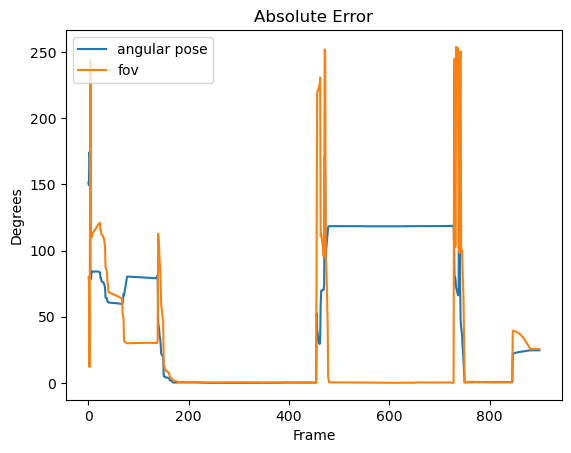

In [25]:
cpe, cpg = utils.load_est_gt_poses(
    in_vid_path, video_width)

cam_params_est, cam_params_gt = utils.set_ref_cam(300, cpe, cpg)

# Compute the angular pose error and hfov error between cam_params and cam_params_gt
angular_err_abs = []
angular_err_rel = []
hfov_err_abs = []
hfov_err_rel = []
cam_indices = []

for i in sorted(cam_params_est.keys()):
    R = cam_params_est[i]['R']
    R_gt = cam_params_gt[i]['R']

    ae = np.degrees(Rot.from_matrix(R @ R_gt.T).magnitude())
    angular_err_abs.append(ae)
    angular_err_rel.append(ae / max(np.degrees(Rot.from_matrix(R_gt.T).magnitude()), 0.1))

    hfove = np.abs(cam_params_est[i]['hfov'] - cam_params_gt[i]['hfov'])
    hfov_err_abs.append(hfove)
    hfov_err_rel.append(hfove / cam_params_gt[i]['hfov'])
    cam_indices.append(i)

# pretty print the mean / max of angular and hfov errors to 5 sf
print(f'angular error mean: {np.mean(angular_err_abs):.5f}, '
      f'max: {np.max(angular_err_abs):.5f}')
print(f'hfov error mean: {np.mean(hfov_err_abs):.5f}, max: {np.max(hfov_err_abs):.5f}')

plt.title('Absolute Error')
plt.plot(angular_err_abs, label='angular pose')
plt.plot(hfov_err_abs, label='fov')
plt.xlabel('Frame')
plt.ylabel('Degrees')
plt.legend()
plt.show()

#plt.title('Relative Error')
#plt.plot(angular_err_rel, label='angular pose')
#plt.plot(hfov_err_rel, label='fov')
#plt.xlabel('Frame')
#plt.legend()
#plt.show()

In [ ]:
angular_err_abs[663]

In [ ]:
A = cam_params_est[662]['R']
B = cam_params_est[663]['R']
print(np.degrees(Rot.from_matrix(A @ B.T).magnitude()))

In [ ]:
for p in closures:
    if p.j - p.i > 400:
        print(p.i, p.j)

In [ ]:
# print magnitude of GT rotations

for i, p in cam_params_gt.items():
    print(f"Frame {i}: {np.degrees(Rot.from_matrix(p['R']).magnitude()):.5f} degrees")

for p in filtered_closures:
    print(f'LC: {p.i} to {p.j}')

for i, e in angular_err_rel.items():
    print(f'Frame {i} error: {e:.3f}%')